In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images as grayscale
image_path_1 = '/home/shared/frontier_data/fnt_802/2024-12-13-10-24-rec001/processed/output_colmap/output/aligned_evo/render/render_novel/rgb/00400.png'
image_path_2 = '/home/shared/frontier_data/fnt_802/2024-12-13-10-36-rec002/processed/output_colmap/output/aligned_evo/render/render_novel/rgb/00400.png'

In [6]:
import torch 
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

sam2_checkpoint = "/home/haedamoh/git/nerf_data_pipeline/nerf_data_pipeline/lerf/checkpoints/sam2/sam2_hiera_large.pt"
model_cfg = "configs/sam2/sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)


using device: cuda


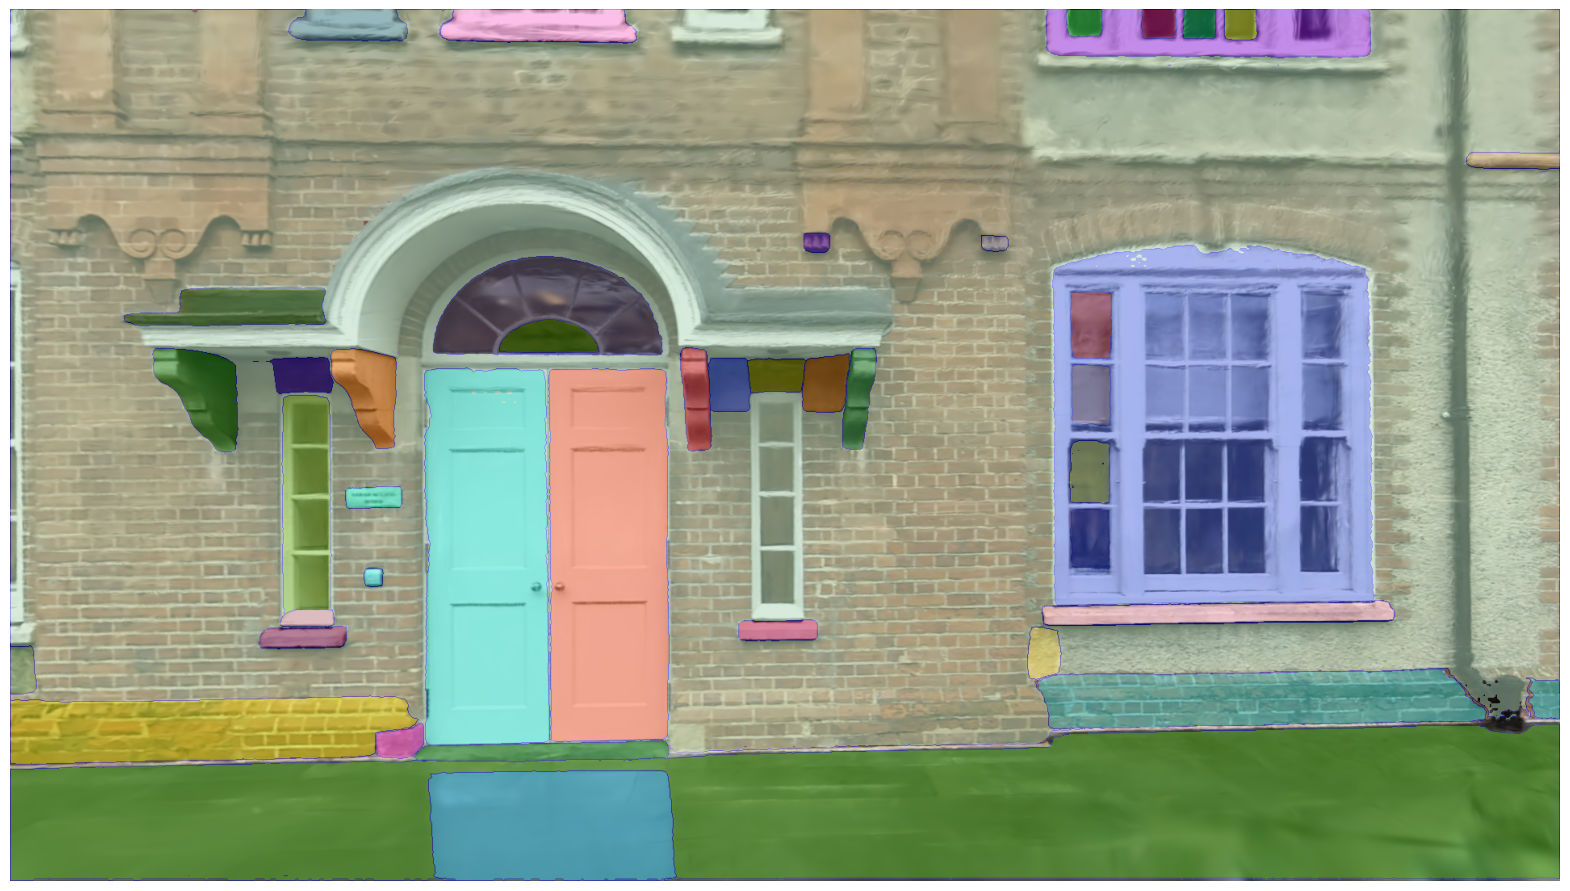

(-0.5, 1919.5, 1079.5, -0.5)

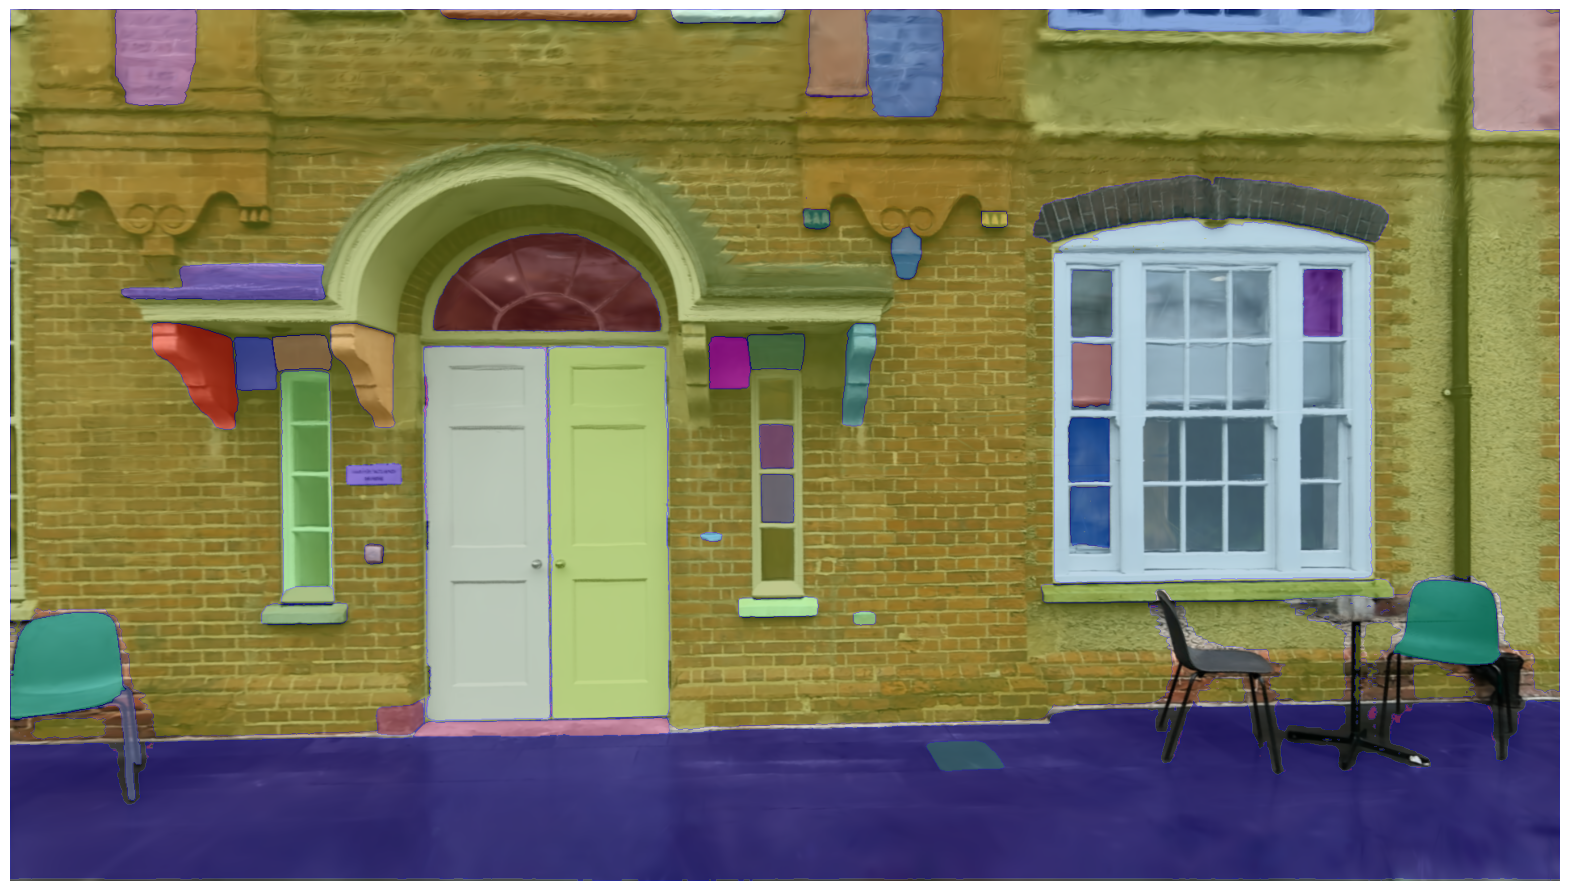

In [8]:
image_1 = Image.open(img1_path)
image_1 = np.array(image_1.convert("RGB"))
masks = mask_generator.generate(image_1)
plt.figure(figsize=(20, 20))
plt.imshow(image_1)
show_anns(masks)
plt.axis('off')
plt.show() 

image_2 = Image.open(img2_path)
image_2 = np.array(image_2.convert("RGB"))
masks = mask_generator.generate(image_2)
plt.figure(figsize=(20, 20))
plt.imshow(image_2)
show_anns(masks)
plt.axis('off')